In [7]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sg
import serial
import time

matplotlib.rcParams['figure.figsize'] = [10, 3]

SAMPLE_NUMS = 260  # sec
SAMPLING_RATE = 80.0  # Hz
GYRO_RESOLUTION = 250.0 / 32768.0
ACCEL_RESOLUTION = 2.0 / 32768.0
RAW_DATA_FILE = './raw_data.csv'
PORT = 'COM8'
TIME_INTERVAL = 260.0 / SAMPLING_RATE  # sec

RIM_SIZE = 20.0 * 2.54 / 100.0  # meter
RIM_DIAMTER = RIM_SIZE * np.pi 

def pulses2speed(pulses):
    running_distance_km = pulses * RIM_DIAMTER / 1000.0
    speed_km_per_hour = running_distance_km / TIME_INTERVAL * 3600.0
    return int(speed_km_per_hour)

In [10]:
ser = serial.Serial(PORT, 115200)
ser.write(b'd')

with open(RAW_DATA_FILE, 'w') as f:
    while True:
        line = ser.readline().decode('ascii')
        if line == '\n':
            break
        f.write(line)
ser.close()

In [11]:
df = pd.read_csv(RAW_DATA_FILE, dtype=np.int16)

gres = lambda v: v * GYRO_RESOLUTION
ares = lambda v: v * ACCEL_RESOLUTION
to_time = lambda v: v / SAMPLING_RATE
df[['gx', 'gy', 'gz']] = df[['gx', 'gy', 'gz']].apply(gres)
df[['ax', 'ay', 'az']] = df[['ax', 'ay', 'az']].apply(ares)
df[['cnt']] = df[['cnt']].apply(to_time)
df.set_index('cnt', drop=True, inplace=True)
measurements = df.tail(1).iloc[0,0] + 1
df.tail()

,id,gx,gy,gz,ax,ay,az,pls
cnt,,,,,,,,
25.9375,7,-1.266479,-3.356934,2.532959,-0.019897,0.036255,0.976074,0
25.9500,7,-3.097534,1.754761,-5.905151,-0.016907,0.036133,0.978516,0
25.9625,7,0.457764,-1.937866,-3.356934,-0.016724,0.038208,0.978821,0
25.9750,7,-0.854492,-0.885010,0.961304,-0.017212,0.041992,0.983765,0
25.9875,7,1.647949,-0.091553,2.807617,-0.022156,0.040649,0.979553,0


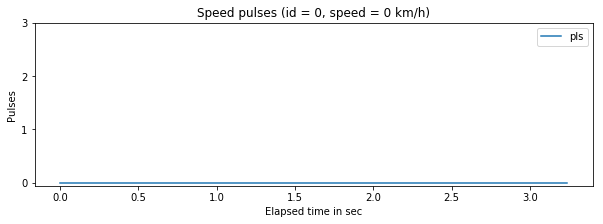

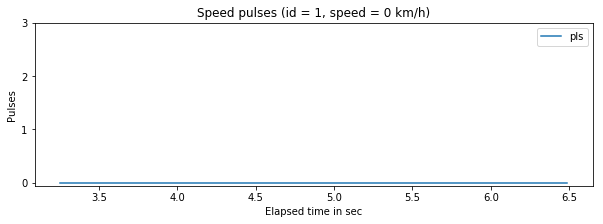

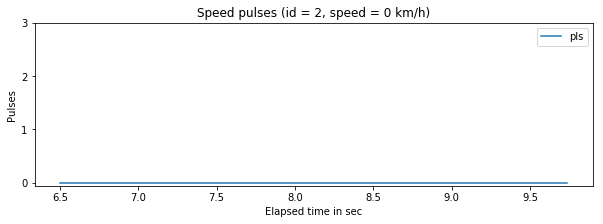

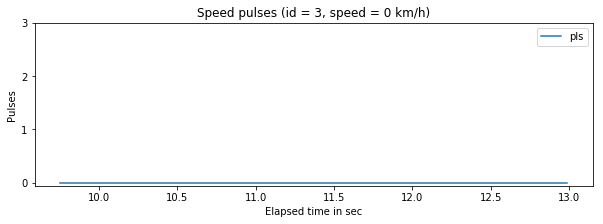

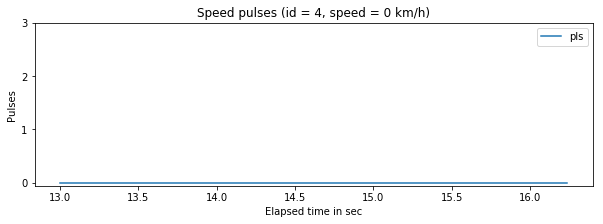

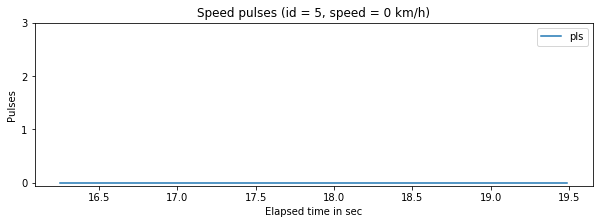

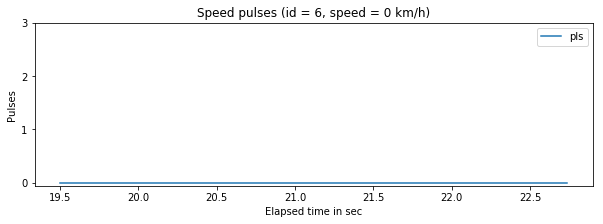

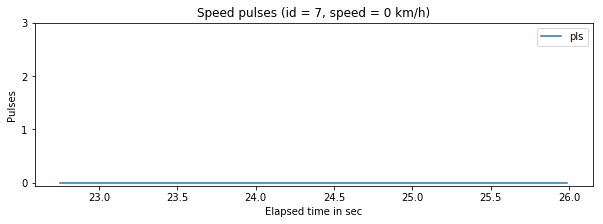

In [12]:
for i in range(measurements):
    df2 = df[df['id']==i]
    ax = df2[['pls']].plot(yticks=[0,1,2,3])
    pulses = df2['pls'].sum()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Pulses')
    ax.set_title('Speed pulses (id = {}, speed = {} km/h)'.format(i, pulses2speed(pulses)))

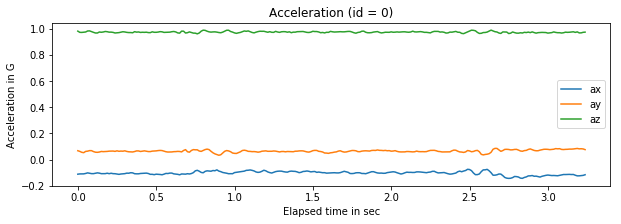

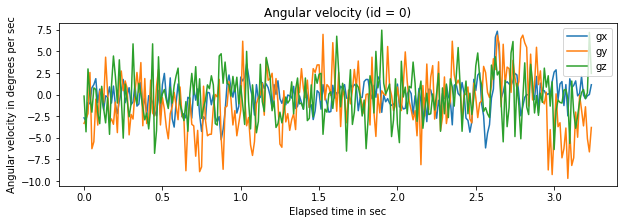

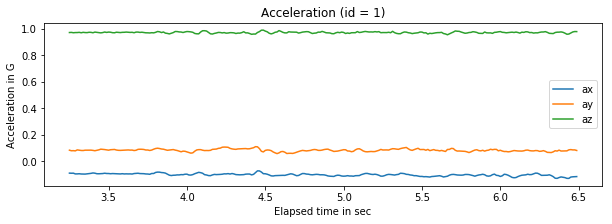

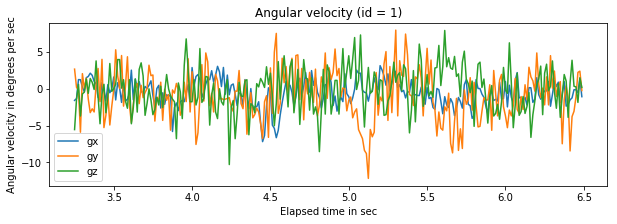

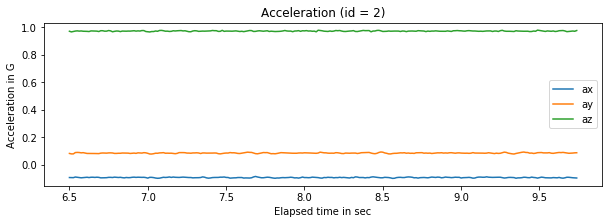

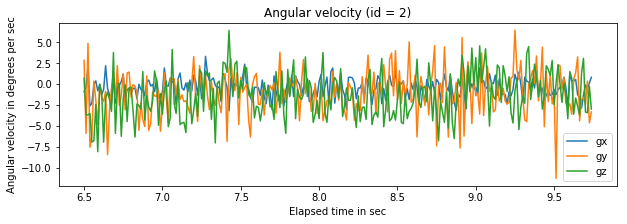

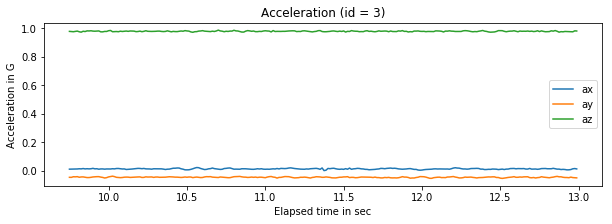

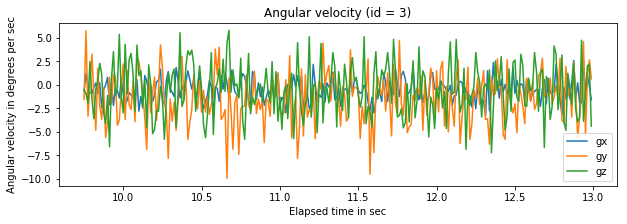

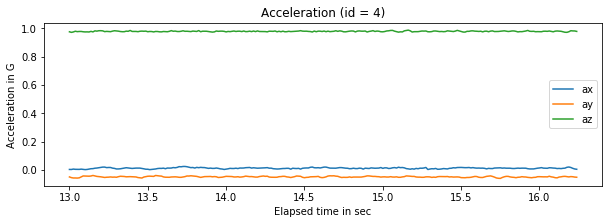

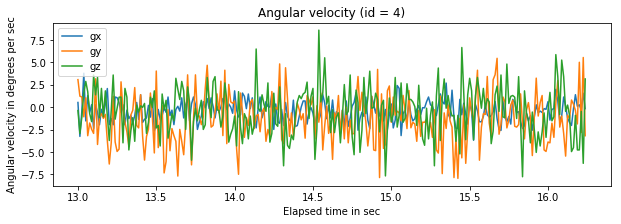

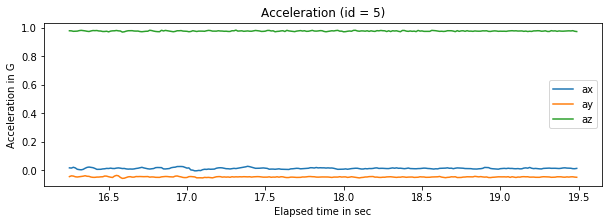

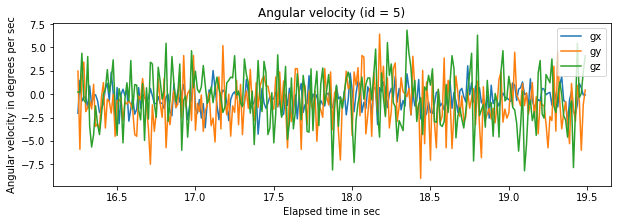

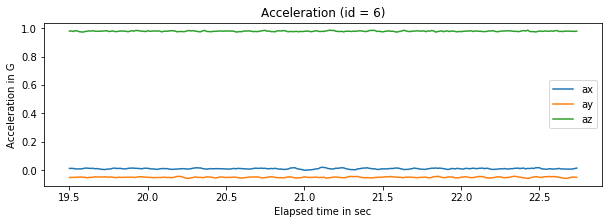

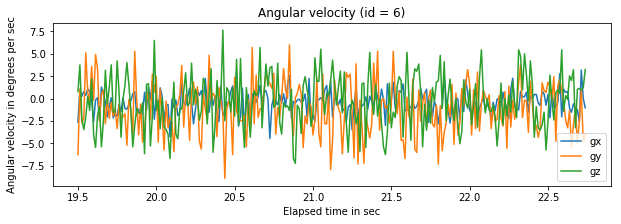

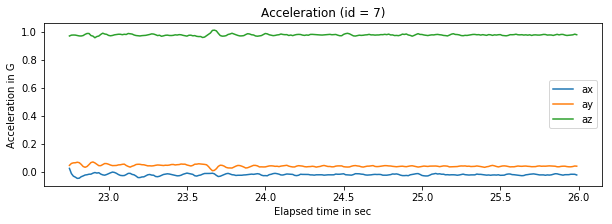

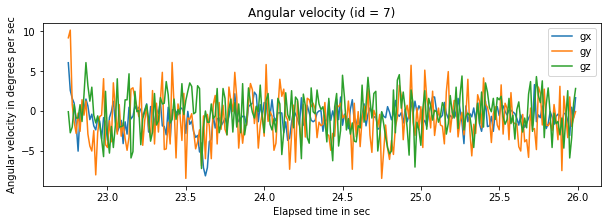

In [13]:
for i in range(measurements):
    df2 = df[df['id']==i]
    ax = df2[['ax', 'ay', 'az']].plot()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Acceleration in G')
    ax.set_title('Acceleration (id = {})'.format(i))
    ax = df2[['gx', 'gy', 'gz']].plot()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Angular velocity in degrees per sec')
    ax.set_title('Angular velocity (id = {})'.format(i))

In [36]:
CUTOFF = 10.0
b, a = sg.butter(5, CUTOFF/SAMPLING_RATE, btype='low')
df[['ax', 'ay', 'az']] = df[['ax', 'ay', 'az']].apply(lambda row: sg.lfilter(b, a, row))

CUTOFF = 3.0
b, a = sg.butter(5, CUTOFF/SAMPLING_RATE, btype='low')
df[['gx', 'gy', 'gz']] = df[['gx', 'gy', 'gz']].apply(lambda row: sg.lfilter(b, a, row))

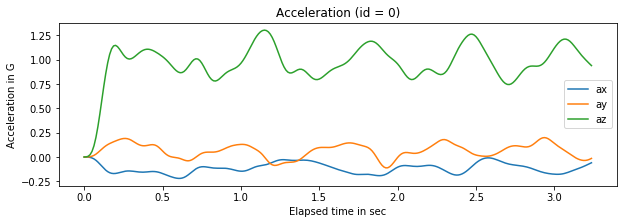

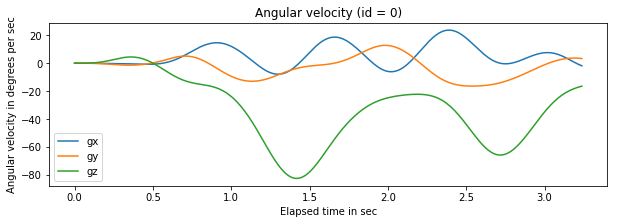

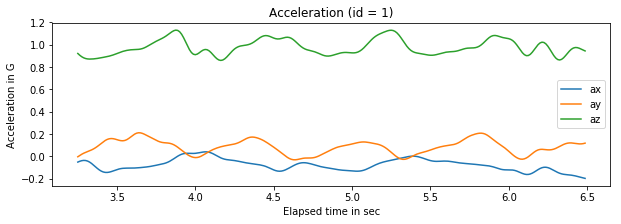

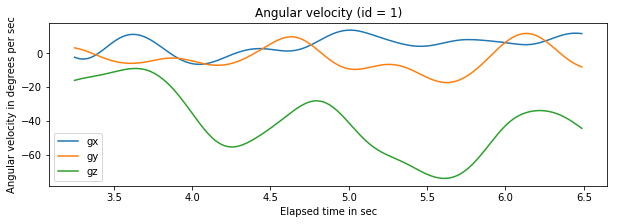

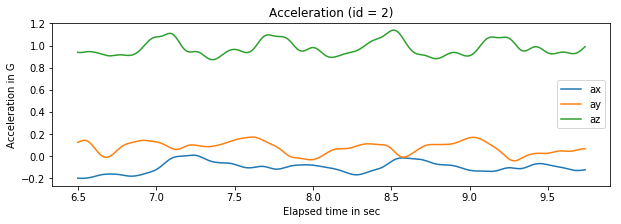

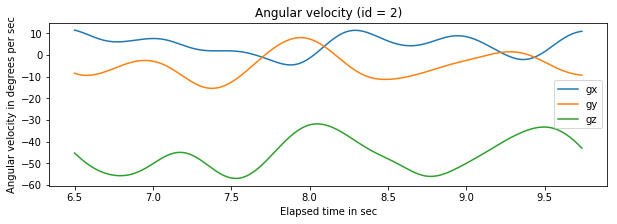

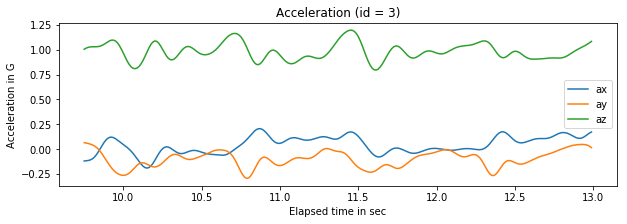

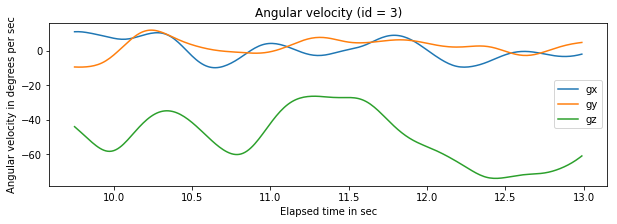

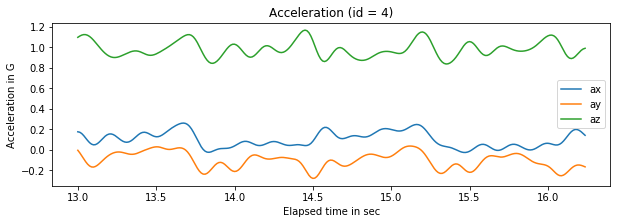

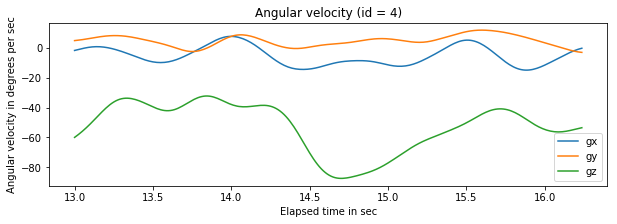

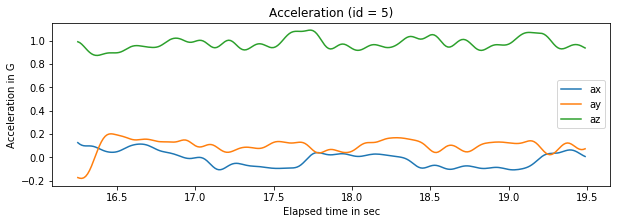

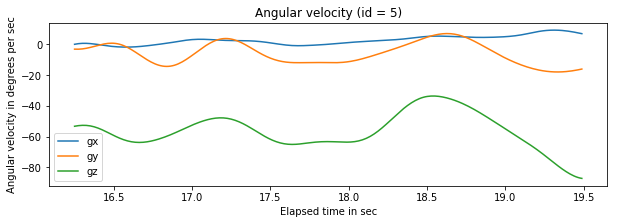

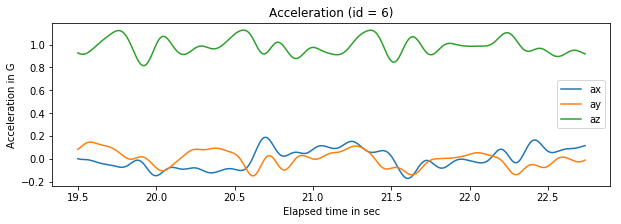

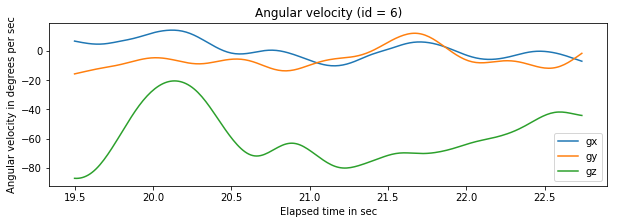

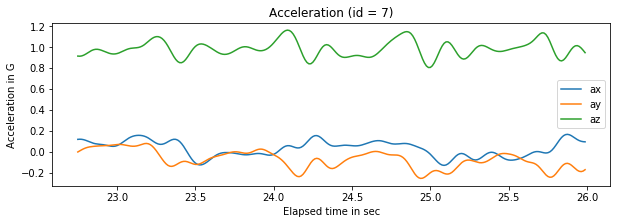

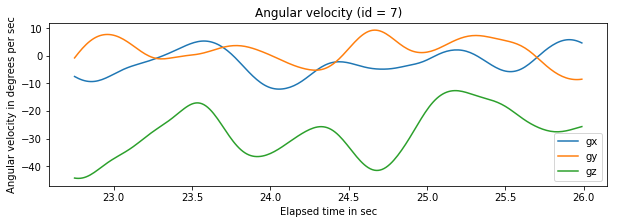

In [37]:
for i in range(measurements):
    df2 = df[df['id']==i]
    ax = df2[['ax', 'ay', 'az']].plot()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Acceleration in G')
    ax.set_title('Acceleration (id = {})'.format(i))
    ax = df2[['gx', 'gy', 'gz']].plot()
    ax.set_xlabel('Elapsed time in sec')
    ax.set_ylabel('Angular velocity in degrees per sec')
    ax.set_title('Angular velocity (id = {})'.format(i))